In [158]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
plt.style.use("ggplot")

In [159]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [160]:
index = list(range(316200))
dataframe = pd.DataFrame(index = index)
dataframe['country'] = ['US','US','US','US','China','China','China','UK','UK','Germany'] * 31620
dataframe['age'] = np.random.randint(0,100,316200)
dataframe['new_user'] = np.random.randint(0,2,316200)
dataframe['total_pages_visited'] = np.random.randint(0,30,316200)
dataframe['converted'] = [1,0,0,0,0,0,0,1,0,0] * 31620
dataframe

,country,age,new_user,total_pages_visited,converted
0,US,73,1,13,1
1,US,89,1,28,0
2,US,51,1,12,0
3,US,33,1,22,0
4,China,91,0,15,0
5,China,10,1,7,0
6,China,15,0,23,0
7,UK,86,1,24,1
8,UK,79,0,20,0
9,Germany,88,0,27,0


In [161]:
dataframe.describe(exclude=None)

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,49.460389,0.499627,14.500528,0.200000
std,28.896749,0.500001,8.656482,0.400001
min,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,7.000000,0.000000
50%,49.000000,0.000000,14.000000,0.000000
75%,74.000000,1.000000,22.000000,0.000000
max,99.000000,1.000000,29.000000,1.000000


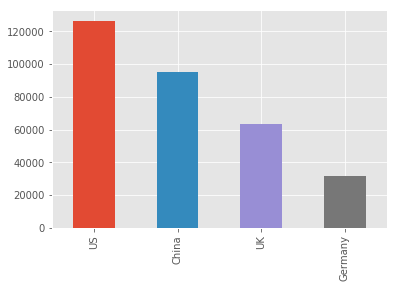

In [162]:
country_dist = dataframe.country.value_counts()
country_dist.plot(kind='bar')

In [163]:
convert_by_country_dist = dataframe.groupby('country')['converted'].mean()
convert_by_country_dist

country
China      0.00
Germany    0.00
UK         0.50
US         0.25
Name: converted, dtype: float64

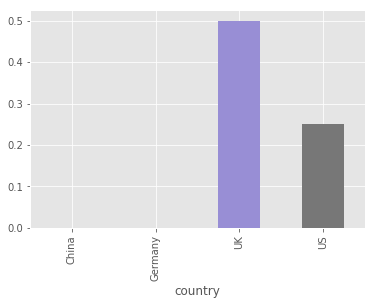

In [164]:
convert_by_country_dist.plot(kind="bar")

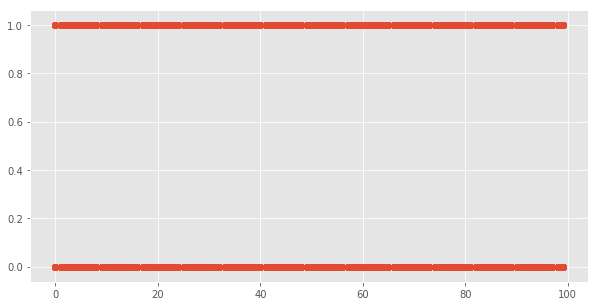

In [165]:
plt.figure(figsize=(10,5))
_ = plt.scatter(dataframe.age, dataframe.converted)

In [166]:
dataframe.head()

,country,age,new_user,total_pages_visited,converted
0,US,73,1,13,1
1,US,89,1,28,0
2,US,51,1,12,0
3,US,33,1,22,0
4,China,91,0,15,0


In [167]:
X = dataframe.loc[:,dataframe.columns.drop('converted')]
X = pd.get_dummies(X,columns = ['country'],prefix='',prefix_sep='')

In [168]:
X.head()

,age,new_user,total_pages_visited,China,Germany,UK,US
0,73,1,13,0,0,0,1
1,89,1,28,0,0,0,1
2,51,1,12,0,0,0,1
3,33,1,22,0,0,0,1
4,91,0,15,1,0,0,0


In [169]:
y = dataframe.converted
y.mean()

0.2

In [170]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.333)

In [171]:
ytrain.mean(), ytest.mean()

(0.19989568763187218, 0.20020893679661902)